<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Generative adversarial networks</b></h3>



В этом домашнем задании вы обучите GAN генерировать лица людей и посмотрите на то, как можно оценивать качество генерации

In [2]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
from torchvision.utils import save_image
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set(style='darkgrid', font_scale=1.2)

## Часть 1. Подготовка данных (1 балл)

В качестве обучающей выборки возьмем часть датасета [Flickr Faces](https://github.com/NVlabs/ffhq-dataset), который содержит изображения лиц людей в высоком разрешении (1024х1024). Оригинальный датасет очень большой, поэтому мы возьмем его часть. Скачать датасет можно [здесь](https://www.kaggle.com/datasets/tommykamaz/faces-dataset-small?resource=download-directory) и  [здесь](https://drive.google.com/drive/folders/14H7LQWzd09SaM11oLfGtd455sWH2rmRW?usp=share_link)

Давайте загрузим наши изображения. Напишите функцию, которая строит DataLoader для изображений, при этом меняя их размер до нужного значения (размер 1024 слишком большой, поэтому мы рекомендуем взять размер 128 либо немного больше)

In [21]:
def get_dataloader(batch_size, data_dir, image_size=128, is_resized=True):
    """
    Builds dataloader for training data.
    Use tt.Compose and tt.Resize for transformations
    :param image_size: height and wdith of the image
    :param batch_size: batch_size of the dataloader
    :param is_resized: images already resized
    :returns: DataLoader object 
    """
    # TODO: resize images, convert them to tensors and build dataloader
    stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

    if is_resized:
        transform =tt.Compose([
            tt.ToTensor(),
            tt.Normalize(*stats),                     
        ])
    else:
        transform=tt.Compose(
            [tt.Resize(image_size),
            tt.CenterCrop(image_size), 
            tt.ToTensor(),
            tt.Normalize(*stats),                     
        ])

    
    train_dataset = ImageFolder(
        root=data_dir, 
        transform=transform
    )

    return DataLoader(train_dataset, batch_size, shuffle=True, num_workers=4, pin_memory=True)
    

In [4]:
image_size = 128
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

DATA_DIR = './data/faces_dataset'
TR_DATA_DIR = './data/faces_dataset_128'
SUB_DIR = '/faces'


In [66]:
# Для предварительной обработки изображений Изменям размер изображения и сохраняем
def prepair_images(image_size):

    # Цепочка трансформаций
    transformations = tt.Compose([
        tt.Resize(image_size),
        tt.CenterCrop(image_size),
        tt.ToTensor()
    ])

    # Загрузим изображения с использованием ImageFolder
    dataset = ImageFolder(root=DATA_DIR, transform=transformations)

    # Создайте каталог, если его нет
    os.makedirs(TR_DATA_DIR + SUB_DIR, exist_ok=True)

    # Сохраняем трансформированные изображения с теми же именами
    for i, (image, _) in enumerate(dataset):
        # Извлечекаем тензор изображения и преобразуем его обратно в изображение PIL
        image_pil = tt.ToPILImage()(image)

        # Составление пути сохранения
        save_path = os.path.join(TR_DATA_DIR, dataset.imgs[i][0].split('/')[-1])

        # Сохранение изображения
        image_pil.save(save_path)

    print(f"Трансформированные изображения сохранены в {TR_DATA_DIR}")

In [67]:
prepair_images(128)

Трансформированные изображения сохранены в ./data/faces_dataset_128


In [ ]:
train_dataloader = get_dataloader(batch_size, TR_DATA_DIR)

In [5]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

In [6]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [7]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

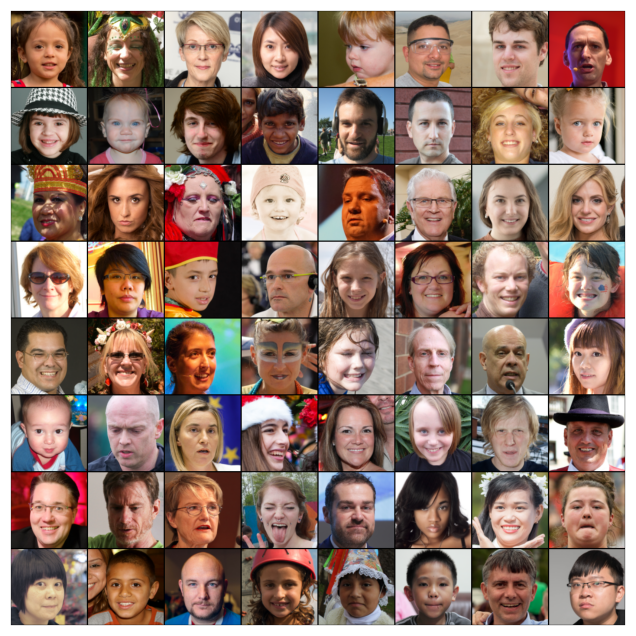

In [74]:
show_batch(train_dataloader)

In [ ]:
train_dataloader = DeviceDataLoader(train_dataloader, device)

## Часть 2. Построение и обучение модели (2 балла)

Сконструируйте генератор и дискриминатор. Помните, что:
* дискриминатор принимает на вход изображение (тензор размера `3 x image_size x image_size`) и выдает вероятность того, что изображение настоящее (тензор размера 1)

* генератор принимает на вход тензор шумов размера `latent_size x 1 x 1` и генерирует изображение размера `3 x image_size x image_size`

In [9]:
discriminator = nn.Sequential(
    # in: 3x 128 x 128
    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 64 x 64

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 32 x 32

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 16 x 16

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 8 x 8

    nn.Conv2d(512, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Dropout(p=0.4),
    nn.Sigmoid()
)

In [10]:
latent_size = 128 # choose latent size

generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
     # out: 512 x 4 x 4
    
    nn.ConvTranspose2d(512, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 8 x 8

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 16 x 16

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 32 x 32

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 64 x 64

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Conv2d(3, 3, kernel_size=1, stride=1, bias=False),
    nn.Tanh()  # output is between -1 to 1
    # out: 3 x 128 x 128
)

In [11]:
discriminator = to_device(discriminator, device)

In [12]:
# generator = torch.load('./data/generator.pt')
generator = to_device(generator, device)

Перейдем теперь к обучению нашего GANа. Алгоритм обучения следующий:
1. Учим дискриминатор:
  * берем реальные изображения и присваиваем им метку 1
  * генерируем изображения генератором и присваиваем им метку 0
  * обучаем классификатор на два класса

2. Учим генератор:
  * генерируем изображения генератором и присваиваем им метку 0
  * предсказываем дискриминаторором, реальное это изображение или нет


В качестве функции потерь берем бинарную кросс-энтропию

In [13]:
lr = 0.0002

model = {
    "discriminator": discriminator,
    "generator": generator
}

criterion = {
    "discriminator": torch.nn.BCELoss(),
    "generator": torch.nn.BCELoss()
}

In [14]:
def fit(model, data, criterion, epochs, lr):
    # TODO: build optimizers and train your GAN
    model["discriminator"].train()
    model["generator"].train()
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    optimizer = {
        "discriminator": torch.optim.Adam(model["discriminator"].parameters(), 
                                          lr=lr, betas=(0.5, 0.999)),
        "generator": torch.optim.Adam(model["generator"].parameters(),
                                      lr=lr, betas=(0.5, 0.999))
    }
    
    for epoch in range(epochs):
        loss_d_per_epoch = []
        loss_g_per_epoch = []
        real_score_per_epoch = []
        fake_score_per_epoch = []
        for real_images, _ in tqdm(data):
            # Train discriminator
            # Clear discriminator gradients
            optimizer["discriminator"].zero_grad()

            # Pass real images through discriminator
            real_preds = model["discriminator"](real_images)
            real_targets = torch.ones(real_images.size(0), 1, device=device)
            real_loss = criterion["discriminator"](real_preds, real_targets)
            cur_real_score = torch.mean(real_preds).item()
            
            # Generate fake images
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)

            # Pass fake images through discriminator
            fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
            fake_preds = model["discriminator"](fake_images)
            fake_loss = criterion["discriminator"](fake_preds, fake_targets)
            cur_fake_score = torch.mean(fake_preds).item()

            real_score_per_epoch.append(cur_real_score)
            fake_score_per_epoch.append(cur_fake_score)

            # Update discriminator weights
            loss_d = real_loss + fake_loss
            loss_d.backward()
            optimizer["discriminator"].step()
            loss_d_per_epoch.append(loss_d.item())


            # Train generator
            # Clear generator gradients
            optimizer["generator"].zero_grad()
            
            # Generate fake images
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)
            
            # Try to fool the discriminator
            preds = model["discriminator"](fake_images)
            targets = torch.ones(batch_size, 1, device=device)
            loss_g = criterion["generator"](preds, targets)
            
            # Update generator weights
            loss_g.backward()
            optimizer["generator"].step()
            loss_g_per_epoch.append(loss_g.item())
            
        # Record losses & scores
        losses_g.append(np.mean(loss_g_per_epoch))
        losses_d.append(np.mean(loss_d_per_epoch))
        real_scores.append(np.mean(real_score_per_epoch))
        fake_scores.append(np.mean(fake_score_per_epoch))
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, 
            losses_g[-1], losses_d[-1], real_scores[-1], fake_scores[-1]))
    
    return losses_g, losses_d, real_scores, fake_scores  

In [15]:
losses_g, losses_d, real_scores, fake_scores = fit(model, train_dataloader, criterion, 150, lr)

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [1/150], loss_g: 9.7631, loss_d: 1.2877, real_score: 0.7199, fake_score: 0.3453


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [2/150], loss_g: 9.4779, loss_d: 1.0517, real_score: 0.7486, fake_score: 0.2777


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [3/150], loss_g: 6.6198, loss_d: 0.9799, real_score: 0.7305, fake_score: 0.2946


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [4/150], loss_g: 4.7378, loss_d: 0.7314, real_score: 0.7488, fake_score: 0.2690


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [5/150], loss_g: 5.0401, loss_d: 0.6746, real_score: 0.7646, fake_score: 0.2479


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [6/150], loss_g: 6.4779, loss_d: 0.6324, real_score: 0.7703, fake_score: 0.2331


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [7/150], loss_g: 5.2430, loss_d: 1.0506, real_score: 0.7065, fake_score: 0.2819


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [8/150], loss_g: 5.1874, loss_d: 0.7310, real_score: 0.7539, fake_score: 0.2595


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [9/150], loss_g: 6.4306, loss_d: 0.8248, real_score: 0.7510, fake_score: 0.2581


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [10/150], loss_g: 5.7884, loss_d: 0.6207, real_score: 0.7822, fake_score: 0.2368


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [11/150], loss_g: 8.1141, loss_d: 0.6487, real_score: 0.7699, fake_score: 0.2207


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [12/150], loss_g: 6.1310, loss_d: 0.7765, real_score: 0.7689, fake_score: 0.2406


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [13/150], loss_g: 6.7716, loss_d: 0.6399, real_score: 0.7749, fake_score: 0.2270


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [14/150], loss_g: 7.4668, loss_d: 0.6333, real_score: 0.7704, fake_score: 0.2215


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [15/150], loss_g: 5.0704, loss_d: 0.5858, real_score: 0.7885, fake_score: 0.2150


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [16/150], loss_g: 3.5740, loss_d: 0.5863, real_score: 0.7863, fake_score: 0.2118


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [17/150], loss_g: 5.4013, loss_d: 0.5810, real_score: 0.7842, fake_score: 0.2059


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [18/150], loss_g: 6.4992, loss_d: 0.5704, real_score: 0.7985, fake_score: 0.2135


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [19/150], loss_g: 5.0557, loss_d: 0.5677, real_score: 0.7906, fake_score: 0.2029


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [20/150], loss_g: 4.8855, loss_d: 0.5720, real_score: 0.7923, fake_score: 0.2079


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [21/150], loss_g: 4.8787, loss_d: 0.5708, real_score: 0.7916, fake_score: 0.2067


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [22/150], loss_g: 4.4136, loss_d: 0.5656, real_score: 0.7918, fake_score: 0.2017


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [23/150], loss_g: 4.2282, loss_d: 0.5506, real_score: 0.8046, fake_score: 0.2035


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [24/150], loss_g: 4.7517, loss_d: 0.5578, real_score: 0.7975, fake_score: 0.2013


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [25/150], loss_g: 4.5109, loss_d: 0.5623, real_score: 0.7982, fake_score: 0.2053


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [26/150], loss_g: 4.5006, loss_d: 0.5699, real_score: 0.8004, fake_score: 0.2125


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [27/150], loss_g: 5.6896, loss_d: 0.8444, real_score: 0.7471, fake_score: 0.2392


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [28/150], loss_g: 6.9197, loss_d: 0.7407, real_score: 0.7508, fake_score: 0.2423


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [29/150], loss_g: 4.7686, loss_d: 0.9061, real_score: 0.7166, fake_score: 0.2821


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [30/150], loss_g: 3.1295, loss_d: 1.1854, real_score: 0.6706, fake_score: 0.3258


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [31/150], loss_g: 2.3606, loss_d: 0.8753, real_score: 0.6859, fake_score: 0.3006


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [32/150], loss_g: 2.5820, loss_d: 0.9389, real_score: 0.6956, fake_score: 0.3139


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [33/150], loss_g: 2.7869, loss_d: 0.8625, real_score: 0.6927, fake_score: 0.3000


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [34/150], loss_g: 2.5398, loss_d: 1.2738, real_score: 0.6408, fake_score: 0.3551


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [35/150], loss_g: 2.2258, loss_d: 0.9299, real_score: 0.6796, fake_score: 0.3327


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [36/150], loss_g: 2.8127, loss_d: 0.8200, real_score: 0.7196, fake_score: 0.2897


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [37/150], loss_g: 3.2461, loss_d: 0.9836, real_score: 0.6998, fake_score: 0.3119


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [38/150], loss_g: 3.2843, loss_d: 0.9468, real_score: 0.6784, fake_score: 0.3078


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [39/150], loss_g: 3.1728, loss_d: 0.9940, real_score: 0.6912, fake_score: 0.3159


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [40/150], loss_g: 3.7183, loss_d: 0.8979, real_score: 0.6987, fake_score: 0.2998


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [41/150], loss_g: 2.5097, loss_d: 1.2304, real_score: 0.6563, fake_score: 0.3415


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [42/150], loss_g: 2.7441, loss_d: 0.9142, real_score: 0.6747, fake_score: 0.3102


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [43/150], loss_g: 3.3269, loss_d: 0.9371, real_score: 0.6939, fake_score: 0.3262


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [44/150], loss_g: 3.1640, loss_d: 0.8914, real_score: 0.6941, fake_score: 0.3166


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [45/150], loss_g: 3.4595, loss_d: 0.8525, real_score: 0.6968, fake_score: 0.3021


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [46/150], loss_g: 3.2846, loss_d: 1.2919, real_score: 0.6511, fake_score: 0.3553


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [47/150], loss_g: 3.3723, loss_d: 0.9880, real_score: 0.6671, fake_score: 0.3175


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [48/150], loss_g: 3.1629, loss_d: 0.9969, real_score: 0.6706, fake_score: 0.3187


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [49/150], loss_g: 3.2054, loss_d: 0.9874, real_score: 0.6746, fake_score: 0.3382


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [50/150], loss_g: 3.4881, loss_d: 1.0002, real_score: 0.6845, fake_score: 0.3390


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [51/150], loss_g: 3.2494, loss_d: 0.9556, real_score: 0.6712, fake_score: 0.3256


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [52/150], loss_g: 3.6620, loss_d: 0.9721, real_score: 0.6803, fake_score: 0.3300


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [53/150], loss_g: 3.4288, loss_d: 0.9176, real_score: 0.6791, fake_score: 0.3085


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [54/150], loss_g: 3.3224, loss_d: 0.9713, real_score: 0.6713, fake_score: 0.3269


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [55/150], loss_g: 3.2585, loss_d: 0.9277, real_score: 0.6793, fake_score: 0.3090


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [56/150], loss_g: 3.8687, loss_d: 0.9970, real_score: 0.6805, fake_score: 0.3255


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [57/150], loss_g: 3.2954, loss_d: 0.8502, real_score: 0.6966, fake_score: 0.3051


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [58/150], loss_g: 3.2073, loss_d: 0.9891, real_score: 0.6712, fake_score: 0.3230


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [59/150], loss_g: 3.1912, loss_d: 0.9633, real_score: 0.6699, fake_score: 0.3301


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [60/150], loss_g: 3.2900, loss_d: 1.0918, real_score: 0.6553, fake_score: 0.3398


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [61/150], loss_g: 2.7804, loss_d: 0.9769, real_score: 0.6672, fake_score: 0.3422


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [62/150], loss_g: 3.2068, loss_d: 1.0561, real_score: 0.6466, fake_score: 0.3570


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [63/150], loss_g: 3.2019, loss_d: 1.0737, real_score: 0.6416, fake_score: 0.3397


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [64/150], loss_g: 3.0853, loss_d: 1.1474, real_score: 0.6414, fake_score: 0.3674


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [65/150], loss_g: 3.0989, loss_d: 0.9488, real_score: 0.6639, fake_score: 0.3258


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [66/150], loss_g: 3.1415, loss_d: 1.0543, real_score: 0.6512, fake_score: 0.3533


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [67/150], loss_g: 3.0404, loss_d: 1.0018, real_score: 0.6720, fake_score: 0.3511


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [68/150], loss_g: 3.1537, loss_d: 1.0626, real_score: 0.6519, fake_score: 0.3423


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [69/150], loss_g: 3.1379, loss_d: 1.0129, real_score: 0.6543, fake_score: 0.3439


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [70/150], loss_g: 2.9605, loss_d: 1.0603, real_score: 0.6537, fake_score: 0.3582


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [71/150], loss_g: 3.2115, loss_d: 0.9899, real_score: 0.6522, fake_score: 0.3220


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [72/150], loss_g: 2.8423, loss_d: 1.0483, real_score: 0.6500, fake_score: 0.3430


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [73/150], loss_g: 2.9437, loss_d: 1.0417, real_score: 0.6570, fake_score: 0.3478


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [74/150], loss_g: 3.0468, loss_d: 0.9840, real_score: 0.6652, fake_score: 0.3256


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [75/150], loss_g: 2.9015, loss_d: 0.9584, real_score: 0.6767, fake_score: 0.3307


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [76/150], loss_g: 3.1709, loss_d: 1.1317, real_score: 0.6455, fake_score: 0.3477


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [77/150], loss_g: 2.8692, loss_d: 0.9799, real_score: 0.6590, fake_score: 0.3420


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [78/150], loss_g: 3.0635, loss_d: 0.9734, real_score: 0.6662, fake_score: 0.3331


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [79/150], loss_g: 3.1739, loss_d: 0.9707, real_score: 0.6646, fake_score: 0.3273


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [80/150], loss_g: 2.9490, loss_d: 0.9223, real_score: 0.6834, fake_score: 0.3239


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [81/150], loss_g: 3.3886, loss_d: 0.9649, real_score: 0.6738, fake_score: 0.3089


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [82/150], loss_g: 3.0856, loss_d: 1.0395, real_score: 0.6730, fake_score: 0.3444


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [83/150], loss_g: 3.1885, loss_d: 1.0419, real_score: 0.6559, fake_score: 0.3425


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [84/150], loss_g: 2.9018, loss_d: 0.8941, real_score: 0.6865, fake_score: 0.3251


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [85/150], loss_g: 3.0133, loss_d: 0.9096, real_score: 0.6879, fake_score: 0.3159


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [86/150], loss_g: 3.2481, loss_d: 0.9335, real_score: 0.6907, fake_score: 0.3288


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [87/150], loss_g: 2.7030, loss_d: 1.0855, real_score: 0.6431, fake_score: 0.3468


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [88/150], loss_g: 3.2199, loss_d: 0.8745, real_score: 0.6892, fake_score: 0.3128


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [89/150], loss_g: 3.4241, loss_d: 0.8772, real_score: 0.6901, fake_score: 0.3074


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [90/150], loss_g: 3.3580, loss_d: 0.9025, real_score: 0.6973, fake_score: 0.3118


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [91/150], loss_g: 3.3421, loss_d: 1.0339, real_score: 0.6592, fake_score: 0.3336


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [92/150], loss_g: 3.1652, loss_d: 0.8572, real_score: 0.6871, fake_score: 0.2989


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [93/150], loss_g: 3.5320, loss_d: 1.0011, real_score: 0.6661, fake_score: 0.3288


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [94/150], loss_g: 3.1254, loss_d: 0.8862, real_score: 0.6866, fake_score: 0.3075


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [95/150], loss_g: 3.1377, loss_d: 1.0398, real_score: 0.6764, fake_score: 0.3441


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [96/150], loss_g: 3.3533, loss_d: 0.9021, real_score: 0.6912, fake_score: 0.3155


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [97/150], loss_g: 3.0071, loss_d: 0.8609, real_score: 0.6889, fake_score: 0.2999


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [98/150], loss_g: 3.1061, loss_d: 0.9145, real_score: 0.6839, fake_score: 0.3106


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [99/150], loss_g: 3.2529, loss_d: 0.8874, real_score: 0.6948, fake_score: 0.3071


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [100/150], loss_g: 3.4792, loss_d: 0.9650, real_score: 0.6682, fake_score: 0.3255


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [101/150], loss_g: 3.0763, loss_d: 0.8474, real_score: 0.7016, fake_score: 0.3017


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [102/150], loss_g: 3.3326, loss_d: 0.9496, real_score: 0.6769, fake_score: 0.3253


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [103/150], loss_g: 3.5490, loss_d: 0.9319, real_score: 0.6853, fake_score: 0.3191


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [104/150], loss_g: 3.2994, loss_d: 0.8210, real_score: 0.6950, fake_score: 0.2903


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [105/150], loss_g: 3.3666, loss_d: 0.9533, real_score: 0.6857, fake_score: 0.3240


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [106/150], loss_g: 3.3025, loss_d: 0.9209, real_score: 0.6923, fake_score: 0.3247


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [107/150], loss_g: 3.3312, loss_d: 0.9408, real_score: 0.6835, fake_score: 0.3124


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [108/150], loss_g: 3.5755, loss_d: 0.9717, real_score: 0.6744, fake_score: 0.3197


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [109/150], loss_g: 3.1553, loss_d: 0.9089, real_score: 0.6841, fake_score: 0.3155


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [110/150], loss_g: 3.5190, loss_d: 0.9028, real_score: 0.6868, fake_score: 0.3109


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [111/150], loss_g: 3.1565, loss_d: 0.8057, real_score: 0.7178, fake_score: 0.2993


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [112/150], loss_g: 3.1850, loss_d: 0.9357, real_score: 0.6762, fake_score: 0.3109


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [113/150], loss_g: 3.0335, loss_d: 0.8746, real_score: 0.6957, fake_score: 0.3051


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [114/150], loss_g: 3.0528, loss_d: 0.9340, real_score: 0.6874, fake_score: 0.3149


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [115/150], loss_g: 3.2546, loss_d: 1.0004, real_score: 0.6679, fake_score: 0.3235


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [116/150], loss_g: 2.7713, loss_d: 0.8685, real_score: 0.6975, fake_score: 0.3022


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [117/150], loss_g: 3.3539, loss_d: 1.0687, real_score: 0.6693, fake_score: 0.3339


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [118/150], loss_g: 2.9546, loss_d: 0.8597, real_score: 0.6880, fake_score: 0.3031


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [119/150], loss_g: 3.0787, loss_d: 0.8879, real_score: 0.6949, fake_score: 0.3132


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [120/150], loss_g: 3.0526, loss_d: 0.8831, real_score: 0.6836, fake_score: 0.3034


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [121/150], loss_g: 3.2216, loss_d: 0.8570, real_score: 0.7025, fake_score: 0.3048


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [122/150], loss_g: 3.3600, loss_d: 0.8568, real_score: 0.6971, fake_score: 0.2930


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [123/150], loss_g: 3.0187, loss_d: 0.7674, real_score: 0.7208, fake_score: 0.2846


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [124/150], loss_g: 3.3557, loss_d: 0.8099, real_score: 0.7112, fake_score: 0.2858


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [125/150], loss_g: 3.3610, loss_d: 0.9540, real_score: 0.6856, fake_score: 0.3220


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [126/150], loss_g: 3.1749, loss_d: 0.8595, real_score: 0.6956, fake_score: 0.2991


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [127/150], loss_g: 3.3338, loss_d: 0.8817, real_score: 0.6994, fake_score: 0.3023


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [128/150], loss_g: 3.4318, loss_d: 0.9474, real_score: 0.6868, fake_score: 0.3147


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [129/150], loss_g: 3.2511, loss_d: 0.8325, real_score: 0.6957, fake_score: 0.2929


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [130/150], loss_g: 2.9856, loss_d: 0.8813, real_score: 0.6899, fake_score: 0.2965


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [131/150], loss_g: 3.3558, loss_d: 0.8370, real_score: 0.7021, fake_score: 0.2997


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [132/150], loss_g: 3.2264, loss_d: 0.8564, real_score: 0.6963, fake_score: 0.2884


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [133/150], loss_g: 3.0232, loss_d: 0.8060, real_score: 0.7066, fake_score: 0.2823


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [134/150], loss_g: 3.2499, loss_d: 0.7971, real_score: 0.7067, fake_score: 0.2786


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [135/150], loss_g: 3.5225, loss_d: 0.9342, real_score: 0.6967, fake_score: 0.3194


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [136/150], loss_g: 3.6522, loss_d: 0.9061, real_score: 0.6943, fake_score: 0.3088


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [137/150], loss_g: 3.5522, loss_d: 0.8697, real_score: 0.6995, fake_score: 0.3006


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [138/150], loss_g: 3.2113, loss_d: 0.8156, real_score: 0.7099, fake_score: 0.2905


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [139/150], loss_g: 3.3315, loss_d: 0.8506, real_score: 0.7003, fake_score: 0.2965


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [140/150], loss_g: 3.0369, loss_d: 0.8255, real_score: 0.7022, fake_score: 0.2790


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [141/150], loss_g: 3.4016, loss_d: 0.9830, real_score: 0.7008, fake_score: 0.3092


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [142/150], loss_g: 3.4192, loss_d: 1.0212, real_score: 0.6693, fake_score: 0.3345


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [143/150], loss_g: 3.2704, loss_d: 0.7886, real_score: 0.7135, fake_score: 0.2896


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [144/150], loss_g: 3.1457, loss_d: 0.8522, real_score: 0.6963, fake_score: 0.2965


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [145/150], loss_g: 3.3887, loss_d: 0.7998, real_score: 0.6989, fake_score: 0.2745


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [146/150], loss_g: 3.2813, loss_d: 0.7953, real_score: 0.7139, fake_score: 0.2812


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [147/150], loss_g: 3.2826, loss_d: 0.7836, real_score: 0.7132, fake_score: 0.2782


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [148/150], loss_g: 3.4662, loss_d: 0.7737, real_score: 0.7218, fake_score: 0.2803


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [149/150], loss_g: 3.3925, loss_d: 0.9316, real_score: 0.6956, fake_score: 0.3063


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [150/150], loss_g: 3.9956, loss_d: 0.8613, real_score: 0.7054, fake_score: 0.2957


Постройте графики лосса для генератора и дискриминатора. Что вы можете сказать про эти графики?

**Ответ**
Графики похожи на графики семинара. По ним видно, что в начале преобладает дискриминатор, затем наступает определенное равновесие. В ходе обучения лосс дискриминатора медленно снижается, но баланс скора сохраняется и лосс генератора снижается незначительно. Это значит, что генератор создает все более качественные изображения.

## Часть 3. Генерация изображений (1 балл)

Теперь давайте оценим качество получившихся изображений. Напишите функцию, которая выводит изображения, сгенерированные нашим генератором

In [16]:
n_images = 48

fixed_latent = torch.randn(n_images, latent_size, 1, 1, device=device)
fake_images = model["generator"](fixed_latent)


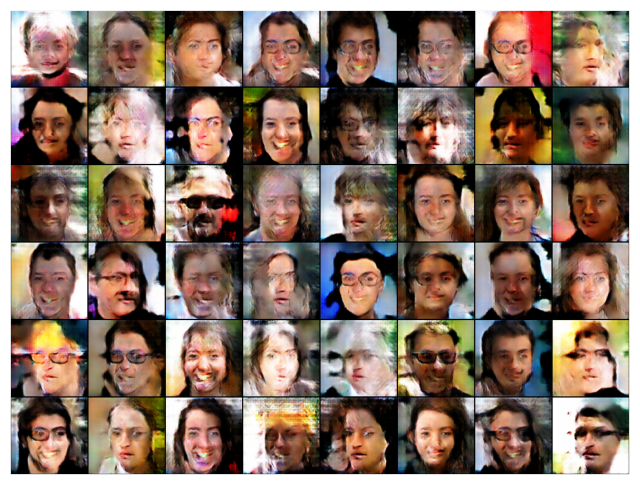

In [17]:
show_images(fake_images.to('cpu'))

In [18]:
#Сохраним веса генератора
torch.save( model["generator"], './data/generator.pt')

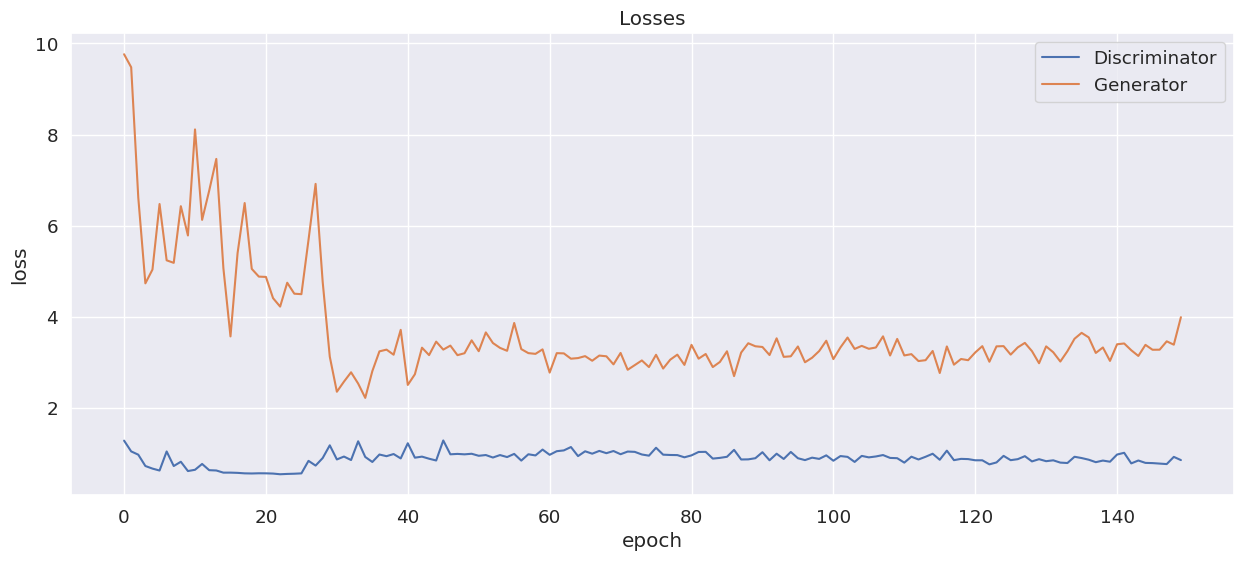

In [19]:
plt.figure(figsize=(15, 6))
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses')
plt.show()

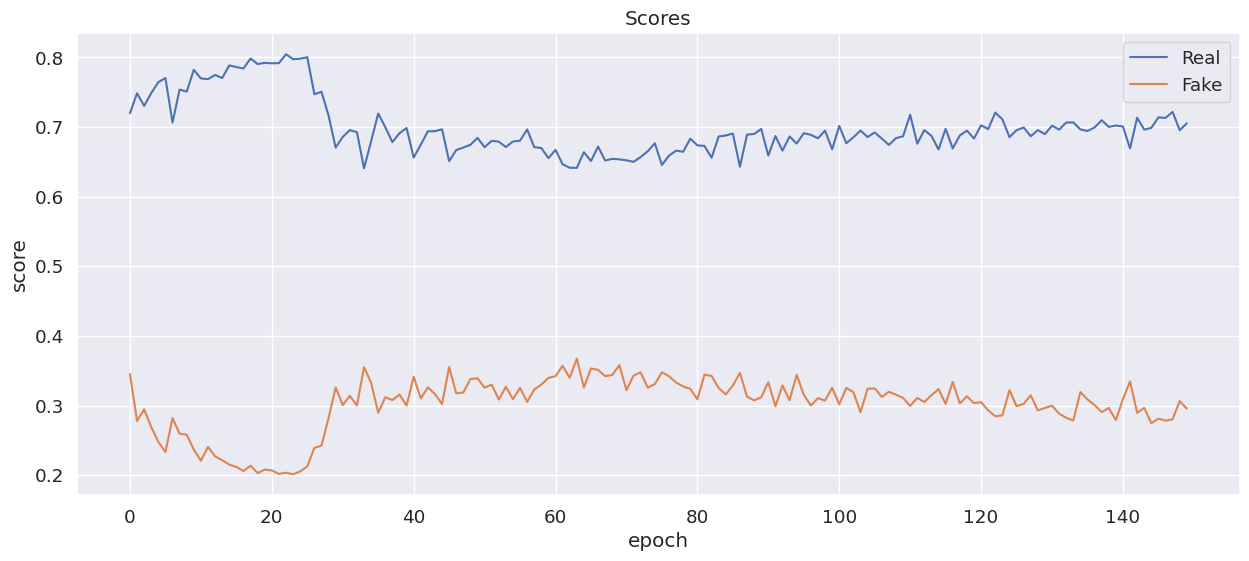

In [20]:
plt.figure(figsize=(15, 6))

plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');

Как вам качество получившихся изображений?

## Часть 4. Leave-one-out-1-NN classifier accuracy (6 баллов)

### 4.1. Подсчет accuracy (4 балла)

Не всегда бывает удобно оценивать качество сгенерированных картинок глазами. В качестве альтернативы вам предлагается реализовать следующий подход:
  * Сгенерировать столько же фейковых изображений, сколько есть настоящих в обучающей выборке. Присвоить фейковым метку класса 0, настоящим – 1.
  * Построить leave-one-out оценку: обучить 1NN Classifier (`sklearn.neighbors.KNeighborsClassifier(n_neighbors=1)`) предсказывать класс на всех объектах, кроме одного, проверить качество (accuracy) на оставшемся объекте. В этом вам поможет `sklearn.model_selection.LeaveOneOut`

In [27]:

FAKE_IMG_DIR = './data/generated/'
os.makedirs(FAKE_IMG_DIR + SUB_DIR, exist_ok=True)

In [29]:


fixed_latent = torch.randn(len(train_dataloader) * batch_size, latent_size, 1, 1, device=device)

for batch_num in range(len(train_dataloader)):
    latent_batch = fixed_latent[batch_num * batch_size: (batch_num+1) * batch_size]
    fake_images = model["generator"](latent_batch)
    for i, fake_image in enumerate(fake_images):
        fake_fname = f'{batch_num * batch_size + i + 1}.png'
        save_image(denorm(fake_image), os.path.join(FAKE_IMG_DIR + SUB_DIR, fake_fname))
    print('Total saving images:', (batch_num + 1) * batch_size)


Total saving images: 128
Total saving images: 256
Total saving images: 384
Total saving images: 512
Total saving images: 640
Total saving images: 768
Total saving images: 896
Total saving images: 1024
Total saving images: 1152
Total saving images: 1280
Total saving images: 1408
Total saving images: 1536
Total saving images: 1664
Total saving images: 1792
Total saving images: 1920
Total saving images: 2048
Total saving images: 2176
Total saving images: 2304
Total saving images: 2432
Total saving images: 2560
Total saving images: 2688
Total saving images: 2816
Total saving images: 2944
Total saving images: 3072
Total saving images: 3200


In [30]:
fake_images_dl = get_dataloader(batch_size, FAKE_IMG_DIR, 32, False)
real_images_dl = get_dataloader(batch_size, TR_DATA_DIR, 32, False)

In [34]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import LeaveOneOut

def get_loss(data, labels):
    loo = LeaveOneOut()
    loss = 0
    for train, test in loo.split(data):
        cls = KNeighborsClassifier(n_neighbors=1)
        cls.fit(data[train], labels[train])
        pred = cls.predict(data[test])
        loss += abs(pred.item()-labels[test].item())
    return loss

In [35]:
fake_labels = torch.zeros(batch_size, 1)
real_labels = torch.ones(batch_size, 1)
labels = torch.cat((fake_labels, real_labels), 0).view(-1)

fake_iter = iter(fake_images_dl)
real_iter = iter(real_images_dl)

loss = 0

for i in range(len(real_images_dl) - 1):
        fake_batch, _ = next(fake_iter)
        real_batch, _ = next(real_iter)
        fake_batch = torch.flatten(fake_batch, 1)
        real_batch = torch.flatten(real_batch, 1)
        data = torch.cat((fake_batch, real_batch), 0)
        loss += get_loss(data, labels)

accuracy = loss / ((len(train_dataloader) - 1) * 2 * batch_size)

print(' Leave-one-out-1-NN classifier accuracy', accuracy)

 Leave-one-out-1-NN classifier accuracy 0.3020833333333333


Что вы можете сказать о получившемся результате? Какой accuracy мы хотели бы получить и почему?

**Ответ**

В данном случае  целевым для нас являлось значение 0, так как это значит, что KNN классификатор не смог разделить на два класса реальные и сгенерированные изображения.

### 4.2. Визуализация распределений (2 балла)

Давайте посмотрим на то, насколько похожи распределения настоящих и фейковых изображений. Для этого воспользуйтесь методом, снижающим размерность (к примеру, TSNE) и изобразите на графике разным цветом точки, соответствующие реальным и сгенерированным изображенияи

In [70]:
from sklearn.manifold import TSNE

t = TSNE()
real = []
generated = []


for batch, _ in real_images_dl:
    
    batch = torch.flatten(batch, 1)
    result = t.fit_transform(batch)
    real.append(result)

for batch, _ in fake_images_dl:
    batch = torch.flatten(batch, 1)
    result = t.fit_transform(batch)
    generated.append(result)

real = np.concatenate(real)
generated = np.concatenate(generated)

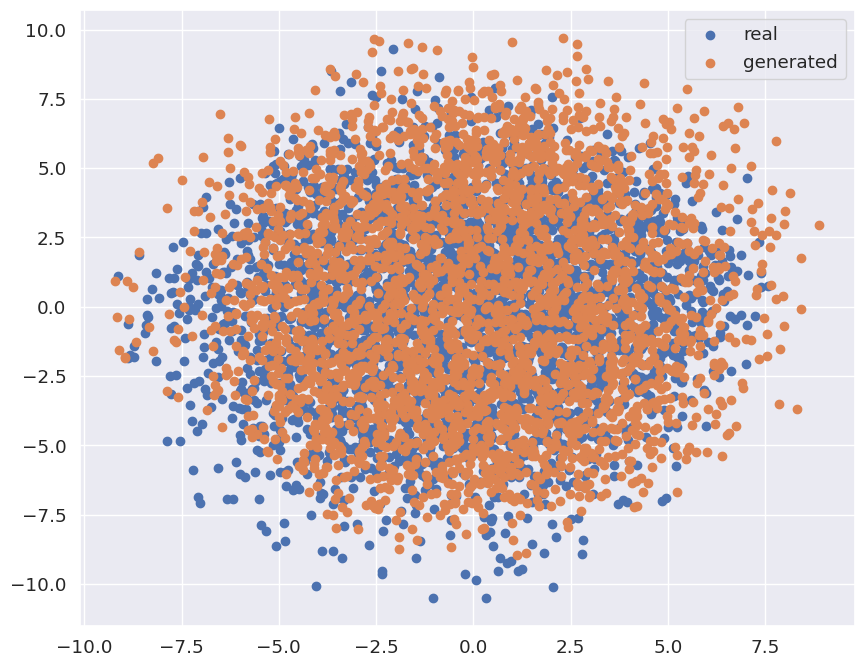

In [71]:
plt.figure(figsize = (10, 8))
plt.scatter(real[:,0], real[:,1], label='real')
plt.scatter(generated[:,0], generated[:,1], label='generated')
plt.legend()
plt.show()

Прокомментируйте получившийся результат:

На графике не видно отдельных кластеров из точек разных классов. Распределение точек реальных изображений и сгенерированных в целом похожи, но для крайних точек разброс или отклонения заметно отличаются. 